In [1]:
using CSV, DataFrames, Dates, Distributions, Extremes, Gadfly

In [2]:
data = CSV.read("dataset/pcp.csv", DataFrame)
filter!(row -> year(row.Date)<2024, data)

filter!(row -> month(row.Date) ∈ 5:10, data)

dropmissing!(data)

first(data, 5)

5×6 DataFrame
 Row │ Longitude  Latitude  Name             ID       Date        pcp     
     │ Float64    Float64   String15         Int64    Date        Float64 
─────┼────────────────────────────────────────────────────────────────────
   1 │    -73.75     45.47  MONTREAL INTL A  7025250  1942-05-01      0.0
   2 │    -73.75     45.47  MONTREAL INTL A  7025250  1942-05-02      0.0
   3 │    -73.75     45.47  MONTREAL INTL A  7025250  1942-05-03     16.5
   4 │    -73.75     45.47  MONTREAL INTL A  7025250  1942-05-04      0.0
   5 │    -73.75     45.47  MONTREAL INTL A  7025250  1942-05-05      0.0

In [3]:
plot(data, x=:Date, y=:pcp, Geom.line)

## Block maxima

À titre de comparaison

In [4]:
data.Year = year.(data.Date)
df_maxima = combine(groupby(data, :Year), :pcp => maximum => :Maximum)
first(df_maxima, 5)

5×2 DataFrame
 Row │ Year   Maximum 
     │ Int64  Float64 
─────┼────────────────
   1 │  1942     45.0
   2 │  1943     54.1
   3 │  1944     25.7
   4 │  1945     37.6
   5 │  1946     52.1

In [5]:
bm = fit(GeneralizedExtremeValue, df_maxima.Maximum)

GeneralizedExtremeValue{Float64}(μ=38.02350480754306, σ=11.105568977109295, ξ=0.005517514300944534)

In [6]:
μ, σ, ξ = params(bm)

(38.02350480754306, 11.105568977109295, 0.005517514300944534)

## Dépassements de seuil

### Choix du seuil

In [7]:
u = 30

df_exceedances = filter(row->row.pcp > u, data)

set_default_plot_size(12cm, 8cm)
plot(df_exceedances, x=:Date, y=:pcp, Geom.point, Theme(discrete_highlight_color=c->nothing),
    yintercept=[u], Geom.hline(color="red", style=:dash))

In [8]:
df_exceedances.exceedance = df_exceedances.pcp .- u

first(df_exceedances, 5)

5×8 DataFrame
 Row │ Longitude  Latitude  Name             ID       Date        pcp      Yea ⋯
     │ Float64    Float64   String15         Int64    Date        Float64  Int ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    -73.75     45.47  MONTREAL INTL A  7025250  1942-08-10     42.2   19 ⋯
   2 │    -73.75     45.47  MONTREAL INTL A  7025250  1942-10-26     45.0   19
   3 │    -73.75     45.47  MONTREAL INTL A  7025250  1943-06-15     54.1   19
   4 │    -73.75     45.47  MONTREAL INTL A  7025250  1943-06-26     35.3   19
   5 │    -73.75     45.47  MONTREAL INTL A  7025250  1943-06-28     32.8   19 ⋯
                                                               2 columns omitted

In [9]:
fm = gpfit(df_exceedances, :exceedance)

MaximumLikelihoodAbstractExtremeValueModel
model :
	ThresholdExceedance
	data :		Vector{Float64}[208]
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

θ̂  :	[2.2971074926874744, 0.03790889191364238]


In [10]:
set_default_plot_size(24cm, 24cm)
diagnosticplots(fm)

In [11]:
σ̃ = σ + ξ*(u-μ)

df = DataFrame(Parameter = String[], GEV=String[], GP = String[])
rename!(df, :GEV => Symbol("GEV => GP"))
push!(df, ["σ", string(round(σ̃, digits=1)), string(round(scale(fm)[], digits=1))])
push!(df, ["ξ", string(round(ξ, digits=2)), string(round(shape(fm)[], digits=2))])

2×3 DataFrame
 Row │ Parameter  GEV => GP  GP     
     │ String     String     String 
─────┼──────────────────────────────
   1 │ σ          11.1       9.9
   2 │ ξ          0.01       0.04

In [12]:
set_default_plot_size(12cm, 8cm)
mrlplot(data.pcp)

In [13]:
df = DataFrame(Threshold = Float64[], σ = Float64[], ξ=Float64[])
x = filter(x -> x>0, data.pcp)

for u in 10:55
    
    z = x .- u
    filter!(z->z>0, z)
    pd = fit(GeneralizedPareto, z, method = "mle")
    
    push!(df, [u, scale(pd), shape(pd)])
    
end

first(df, 5)

5×3 DataFrame
 Row │ Threshold  σ        ξ           
     │ Float64    Float64  Float64     
─────┼─────────────────────────────────
   1 │      10.0  10.2635   0.0150876
   2 │      11.0  10.3507   0.0119881
   3 │      12.0  10.113    0.0252831
   4 │      13.0  10.7258  -0.00423905
   5 │      14.0  10.403    0.0119715

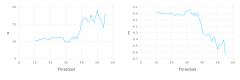

In [14]:
fig1 = plot(df, x=:Threshold, y=:σ, Geom.line)
fig2 = plot(df, x=:Threshold, y=:ξ, Geom.line)

set_default_plot_size(24cm, 8cm)
hstack(fig1, fig2)

## Extrapolation

In [15]:
n = nrow(data)
nₒ = (Date(1942,10,31) - Date(1942,5,1)).value

rl = returnlevel(fm, u, n, nₒ, 100)

rl.value

1-element Vector{Float64}:
 91.22184489412692

In [16]:
cint(rl)

1-element Vector{Vector{Real}}:
 [70.50338990777801, 111.94029988047582]